<a href="https://colab.research.google.com/github/FL24-Team-2018/DP-Experiment/blob/master/analysis/fit_CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# preamble

In [29]:
#!pip install lmfit

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, loadtxt, pi, sqrt
import xlrd
import pandas as pd
from lmfit import Model

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.gridspec as gridspec

# Import Data

In [31]:
url = 'C:\\Users\\Thomas\\OneDrive\\PhD\\DP-Experiment\\analysis\\2020-01-09 results Wiener.xlsx'
df = pd.read_excel(url) # file needs to be closed. workaround: open in office online

In [32]:
df.columns

Index(['measurement', 'label', 'ph', 'bg', 'wavelength / nm', 'd / um',
       'd / σ_B', 'd / σ_B err', 'orientation', 'pinholes_bg_avg_sx_um_mean',
       'pinholes_bg_avg_sx_um_std', 'pinholes_bg_avg_sx_um_min',
       'pinholes_bg_avg_sx_um_max', 'pinholes_bg_avg_sy_um_mean',
       'pinholes_bg_avg_sy_um_std', 'pinholes_bg_avg_sy_um_min',
       'pinholes_bg_avg_sy_um_max', 'sigma_B_old / um', 'sigma_B_err / % old',
       'sigma_B_err / um old', 'sigma_B / um', 'sigma_B_err / um',
       'sigma_B_err / %', 'xi_0 / um', 'xi_0 std / um', 'xi_0_std / %',
       'xi_0/σ_B', 'xi_0/σ_B std', 'xi_0/σ_B err', 'zeta_0', 'zeta_0 std',
       '(xi_x - xi_0) / xi_0', 'xi_x / um', 'xi_x std / um', 'xi_x std',
       'xi_x_max / um', 'xi_y / um', 'xi_y std / um', 'xi_y std / 1',
       'xi_y_max / um', 'Unnamed: 40', 'xi_x/σ_B', 'xi_x/σ_B std', 'zeta_x',
       'zeta_x std', 'xi_y/σ_B', 'xi_y/σ_B std', 'zeta_y', 'zeta_y std',
       'gamma_fit', 'gamma_fit_stderr', 'gamma_fit_min', 'gamma_fit_

In [33]:
url = 'C:\\Users\\Thomas\\OneDrive\\PhD\\DP-Experiment\\analysis\\df0.csv'
df0 = pd.read_csv(url) # file needs to be closed. workaround: open in office online

In [34]:
df0.columns

Index(['Unnamed: 0', 'hdf5_file_name', 'begin', 'end', 'pinholes', 'threshold',
       'checked', 'aperture5_mm', 'aperture7_mm', 'filter', 'separation_um',
       'orientation', 'timestamp_t_sec', 'timestamp_t_microsec',
       'timestamp_pulse_id', 'mean wavelength', 'mean photon energy',
       'SASE03 gap', 'SASE04 gap', 'SASE05 gap', 'SASE06 gap', 'SASE07 gap',
       'SASE08 gap', 'SASE09 gap', 'SASE10 gap', 'SASE11 gap', 'SASE12 gap',
       'SASE13 gap', 'SASE14 gap', 'set wavelength', 'average energy hall',
       'average energy tunnel', 'beam position hall horizontal average',
       'beam position hall vertical average',
       'beam position tunnel horizontal average',
       'beam position tunnel vertical average',
       'beam position hall horizontal pulse resolved',
       'beam position hall vertical pulse resolved',
       'beam position tunnel horizontal pulse resolved',
       'beam position tunnel vertical pulse resolved', 'energy aux hall',
       'energy aux tun

In [35]:
df0['separation_um'].unique().tolist()

[50.0, 107.0, 215.0, 322.0, 445.0, 707.0, 890.0, 1047.0, 1335.0, 1570.0]

In [36]:
def get_imageids_with_bgs(beamposition_horizontal_interval):

    imageid_sequence = []
    for imageid in df0[(df0['hdf5_file_name'] == hdf5_file_name_image_widget.value) & (df0['pinholes'] == dataset_image_args_widget.value[2])].sort_values('beam position hall horizontal pulse resolved')['imageid']:
        beamposition_horizontal_image = df0[(df0['hdf5_file_name'] == hdf5_file_name_image_widget.value) & (df0['pinholes'] == dataset_image_args_widget.value[2])]['beam position hall horizontal pulse resolved'][imageid]
        matching_bg_indices = df0[(df0['hdf5_file_name'] == hdf5_file_name_bg_widget.value) & (df0['pinholes'] == dataset_bg_args_widget.value[2]) & (df0['beam position hall horizontal pulse resolved'] > beamposition_horizontal_image - beamposition_horizontal_interval/2 ) & (df0['beam position hall horizontal pulse resolved'] < beamposition_horizontal_image + beamposition_horizontal_interval/2 ) ]['beam position hall horizontal pulse resolved'].index
        if matching_bg_indices.empty == False:
            imageid_sequence.append(imageid)
    
    return imageid_sequence


In [38]:
setting_undulators_selection = setting_undulators_selection_widget.value
wavelength_nm_selection = wavelength_nm_selection_widget.value
orientation_selection = orientation_selection_widget.value
separation_um_selection = separation_um_selection_widget.value

# which xi_x_um_fit make no sense?
xi_x_um_fit_upper_limit = 3000
outlierindex = df0[(df0['setting_undulators'].isin(setting_undulators_selection)) \
    & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) \
    & (df0['orientation'].isin(orientation_selection)) \
    & (df0['separation_um'].isin(separation_um_selection)) \
    & (df0['xi_x_um_fit']>xi_x_um_fit_upper_limit)]['imageid'].index
outlierindex

Int64Index([6116], dtype='int64')

In [39]:
# clean up
for i in outlierindex:
    df0.at[df0.index[i], 'xi_x_um_fit'] = np.nan
    df0.at[df0.index[i], 'gamma_fit'] = np.nan

In [37]:
setting_undulators_selection_widget = widgets.SelectMultiple(
    options=df0['setting_undulators'].unique().tolist(),
    value=df0['setting_undulators'].unique().tolist(),
    #rows=10,
    description='#undulators',
    disabled=False
)

wavelength_nm_selection_widget = widgets.SelectMultiple(
    options=[8, 13.5, 18],
    value=[8, 13.5, 18],
    #rows=10,
    description='$\lambda~/~$nm',
    disabled=False
)

orientation_selection_widget = widgets.SelectMultiple(
    options=df0['orientation'].unique().tolist(),
    value=df0['orientation'].unique().tolist(),
    #rows=10,
    description='orientation',
    disabled=False
)

separation_um_selection_widget = widgets.SelectMultiple(
    options=df0['separation_um'].unique().tolist(),
    value=df0['separation_um'].unique().tolist(),
    #rows=10,
    description='$d$ / um',
    disabled=False
)

select_inner_ten_widget = widgets.Checkbox(
    value=False,
    description='Only 10 inner images',
    disabled=False
)
   
cparameter_options = ['_lambda_nm_fit', 
                      'energy hall', 
                      'separation_um',
                      'd_um_at_detector', 
                      'pixis_profile_centerx_px_fit', 
                      'shiftx_um_fit', 
                      'w1_um_fit', 'w2_um_fit',
                      'I_Airy1_fit', 'I_Airy2_fit', 
                      'x1_um_fit', 'x2_um_fit', 
                      'xi_y_um', 
                      'beam position hall horizontal pulse resolved',
                      'beam position hall vertical pulse resolved',
                     'setting_undulators']
cparameter_widget = widgets.Dropdown(options=cparameter_options)

    
def plot_xi_deconv_vs_fit(setting_undulators_selection, wavelength_nm_selection, orientation_selection, separation_um_selection, imageid_selection, cparameter):

    fig = plt.figure()
    ax = plt.subplot(111)

    x = df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection)) & (df0['separation_um'].isin(separation_um_selection)) & (df0['imageid'].isin(imageid_selection))]['xi_x_um_fit']
    y = df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection))& (df0['separation_um'].isin(separation_um_selection)) & (df0['imageid'].isin(imageid_selection))]['xi_x_um']

    c = df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection))& (df0['separation_um'].isin(separation_um_selection)) & (df0['imageid'].isin(imageid_selection))][cparameter]


    plt.plot([0,1500], [0,1500], linestyle='dashed', color='red', linewidth=1)
    # plt.scatter(x, y, c=c, s=5, cmap='rainbow', edgecolors='black', linewidths=0.1)
    plt.scatter(x, y, c=c, s=5, cmap='plasma', edgecolors='black', linewidths=0.1)
    plt.colorbar(label=cparameter)

    plt.xlabel('xi_x_um_fit')
    plt.ylabel('xi_x_um_deconv')
#     plt.xlim([-1000,1500])

#     print(df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection)) & (df0['separation_um'].isin(separation_um_selection))][['pinholes_bg_avg_sx_um', 'pinholes_bg_avg_sy_um', 'xi_x_um_fit','zeta_x', 'zeta_x_fit']])
    
#     print(df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection)) & (df0['separation_um'].isin(separation_um_selection))][['pinholes_bg_avg_sx_um']].mean())
#     print(df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection)) & (df0['separation_um'].isin(separation_um_selection))][['pinholes_bg_avg_sx_um']].std())
#     print(df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection)) & (df0['separation_um'].isin(separation_um_selection))][['pinholes_bg_avg_sy_um']].mean())
    
def plot_xi_deconv_vs_fit_interact(setting_undulators_selection, wavelength_nm_selection, orientation_selection, separation_um_selection, select_inner_ten, cparameter):
    imageid_sequence_by_energy_hall = df0[(df0['setting_undulators'].isin(setting_undulators_selection)) \
        & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) \
        & (df0['orientation'].isin(orientation_selection)) \
        & (df0['separation_um'].isin(separation_um_selection))].sort_values('beam position hall horizontal pulse resolved')['imageid'].unique().tolist()
    imageid_selection = imageid_sequence_by_energy_hall
    sequence_center = int((len(imageid_selection)-1)/2)
    if (select_inner_ten == True) & (len(df0[(df0['setting_undulators'].isin(setting_undulators_selection)) & (df0['setting_wavelength_nm'].isin(wavelength_nm_selection)) & (df0['orientation'].isin(orientation_selection))& (df0['separation_um'].isin(separation_um_selection)) & (df0['imageid'].isin(imageid_selection))]['xi_x_um'].unique())!=11):
        # quick run:
        imageid_selection = imageid_selection[sequence_center-5:sequence_center+5]
    
        
    plot_xi_deconv_vs_fit(setting_undulators_selection, wavelength_nm_selection, orientation_selection, separation_um_selection, imageid_selection, cparameter)

    
input_widgets = widgets.VBox(
    [widgets.HBox([setting_undulators_selection_widget, \
                  wavelength_nm_selection_widget, \
                  orientation_selection_widget, \
                 separation_um_selection_widget]), \
     widgets.HBox([select_inner_ten_widget, \
                 cparameter_widget])])

out = widgets.interactive_output(plot_xi_deconv_vs_fit_interact, \
         {'setting_undulators_selection' : setting_undulators_selection_widget , \
          'wavelength_nm_selection' : wavelength_nm_selection_widget , \
          'orientation_selection' : orientation_selection_widget , \
         'separation_um_selection' : separation_um_selection_widget, \
          'select_inner_ten' : select_inner_ten_widget, \
         'cparameter' : cparameter_widget})

display(input_widgets, out)

Output()

# Fitting

In [40]:
def gaussian(x, amp, cen, sigma):
    """1-d gaussian: gaussian(x, amp, cen, sigma)"""
    return (amp  * exp(-(x-cen)**2 / (2*sigma**2)))

# How to include error bars in lmfit when fitting data to Gaussian profile?
# https://stackoverflow.com/questions/56412962/how-to-include-error-bars-in-lmfit-when-fitting-data-to-gaussian-profile

def find_sigma(x,y, dely, sigma_init, use_dely):

    mymodel = Model(gaussian)
    sigma_init = 700
    params = mymodel.make_params(amp=1, cen=0, sigma=sigma_init)
    params['amp'].vary = False
    params['cen'].vary = False
    mymodel.set_param_hint('sigma', value=sigma_init)

    if use_dely == True:
        result = mymodel.fit(y, params, x=x, weights=np.divide([1.0],dely))       
    else:
        result = mymodel.fit(y, params, x=x)

    xi_um_fit = result.params['sigma'].value
    xi_um_fit_stderr = result.params['sigma'].stderr

    delmodel = result.eval_uncertainty()
        
    #print(result.fit_report())
    
    return (xi_um_fit, xi_um_fit_stderr)

In [41]:
def zeta(xi,s):
    zeta = (xi/s) / sqrt(4 + (xi/s)**2)
    return zeta

In [42]:
label = '8nm vertical S'
xdata_8nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_8nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_8nm_S_ver_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_8nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_8nm_S_ver, xi_um_fit_stderr_8nm_S_ver) = find_sigma(xdata_8nm_S_ver,ydata_8nm_S_ver,ydata_std_8nm_S_ver, 400, True)
(xi_um_fit_8nm_S_ver_max, xi_um_fit_stderr_8nm_S_ver_max) = find_sigma(xdata_8nm_S_ver,ydata_8nm_S_ver_max,0, 400, False)

label = '8nm horizontal S'
xdata_8nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_8nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_8nm_S_hor_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_8nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_8nm_S_hor, xi_um_fit_stderr_8nm_S_hor) = find_sigma(xdata_8nm_S_hor,ydata_8nm_S_hor,ydata_std_8nm_S_hor, 400, True)
(xi_um_fit_8nm_S_hor_max, xi_um_fit_stderr_8nm_S_hor_max) = find_sigma(xdata_8nm_S_hor,ydata_8nm_S_hor_max,0, 400, False)

label = '13.5nm vertical S'
xdata_13p5nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_13p5nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_13p5nm_S_ver_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_13p5nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_13p5nm_S_ver, xi_um_fit_stderr_13p5nm_S_ver) = find_sigma(xdata_13p5nm_S_ver,ydata_13p5nm_S_ver,ydata_std_13p5nm_S_ver, 400, True)
(xi_um_fit_13p5nm_S_ver_max, xi_um_fit_stderr_13p5nm_S_ver_max) = find_sigma(xdata_13p5nm_S_ver,ydata_13p5nm_S_ver_max,0, 400, False)

label = '13.5nm horizontal S'
xdata_13p5nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_13p5nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_13p5nm_S_hor_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_13p5nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_13p5nm_S_hor, xi_um_fit_stderr_13p5nm_S_hor) = find_sigma(xdata_13p5nm_S_hor,ydata_13p5nm_S_hor,ydata_std_13p5nm_S_hor, 400, True)
(xi_um_fit_13p5nm_S_hor_max, xi_um_fit_stderr_13p5nm_S_hor_max) = find_sigma(xdata_13p5nm_S_hor,ydata_13p5nm_S_hor_max,0, 400, False)

label = '18nm vertical S'
xdata_18nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_18nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_18nm_S_ver_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_18nm_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_18nm_S_ver, xi_um_fit_stderr_18nm_S_ver) = find_sigma(xdata_18nm_S_ver,ydata_18nm_S_ver,ydata_std_18nm_S_ver, 700, True)
(xi_um_fit_18nm_S_ver_max, xi_um_fit_stderr_18nm_S_ver_max) = find_sigma(xdata_18nm_S_ver,ydata_18nm_S_ver_max, 0, 700, False)

label = '18nm horizontal S'
xdata_18nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_18nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_18nm_S_hor_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_18nm_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_18nm_S_hor, xi_um_fit_stderr_18nm_S_hor) = find_sigma(xdata_18nm_S_hor,ydata_18nm_S_hor,ydata_std_18nm_S_hor, 700, True)
(xi_um_fit_18nm_S_hor_max, xi_um_fit_stderr_18nm_S_hor_max) = find_sigma(xdata_18nm_S_hor,ydata_18nm_S_hor_max, 0, 700, False)

label = '13.5nm#1 vertical S'
xdata_13p5nm_1_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_13p5nm_1_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_13p5nm_1_S_ver_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_13p5nm_1_S_ver = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_13p5nm_1_S_ver, xi_um_fit_stderr_13p5nm_1_S_ver) = find_sigma(xdata_13p5nm_1_S_ver,ydata_13p5nm_1_S_ver,ydata_std_13p5nm_1_S_ver, 400, True)
(xi_um_fit_13p5nm_1_S_ver_max, xi_um_fit_stderr_13p5nm_1_S_ver_max) = find_sigma(xdata_13p5nm_1_S_ver,ydata_13p5nm_1_S_ver_max,0, 400, False)

label = '13.5nm#1 horizontal S'
xdata_13p5nm_1_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['d / um']
ydata_13p5nm_1_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit']
ydata_13p5nm_1_S_hor_max = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_max']
ydata_std_13p5nm_1_S_hor = df[(df['label']==label) & ~(df['gamma_fit'].isna())]['gamma_fit_stderr']
(xi_um_fit_13p5nm_1_S_hor, xi_um_fit_stderr_13p5nm_1_S_hor) = find_sigma(xdata_13p5nm_1_S_hor,ydata_13p5nm_1_S_hor,ydata_std_13p5nm_1_S_hor, 400, True)
(xi_um_fit_13p5nm_1_S_hor_max, xi_um_fit_stderr_13p5nm_1_S_hor_max) = find_sigma(xdata_13p5nm_1_S_hor,ydata_13p5nm_1_S_hor_max,0, 400, False)


In [43]:
label = '8nm horizontal S'
d_um_0_8nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_8nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_8nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_8nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_8nm_S_hor = zeta(xi_um_fit_8nm_S_hor,sigma_B_um_8nm_S_hor)
zeta_fit_um_std_8nm_S_hor = xi_um_fit_stderr_8nm_S_ver/xi_um_fit_8nm_S_ver
zeta_fit_um_8nm_S_hor_max = zeta(xi_um_fit_8nm_S_hor_max,sigma_B_um_8nm_S_hor)
zeta_fit_um_std_8nm_S_hor_max = xi_um_fit_stderr_8nm_S_ver_max/xi_um_fit_8nm_S_ver_max

label = '8nm vertical S'
d_um_0_8nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_8nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_8nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_8nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_8nm_S_ver = zeta(xi_um_fit_8nm_S_ver,sigma_B_um_8nm_S_ver)
zeta_fit_um_std_8nm_S_ver = xi_um_fit_stderr_8nm_S_ver/xi_um_fit_8nm_S_ver
zeta_fit_um_8nm_S_ver_max = zeta(xi_um_fit_8nm_S_ver_max,sigma_B_um_8nm_S_ver)
zeta_fit_um_std_8nm_S_ver_max = xi_um_fit_stderr_8nm_S_ver_max/xi_um_fit_8nm_S_ver_max


label = '13.5nm horizontal S'
d_um_0_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_13p5nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_13p5nm_S_hor = zeta(xi_um_fit_13p5nm_S_hor,sigma_B_um_13p5nm_S_hor)
zeta_fit_um_std_13p5nm_S_hor = xi_um_fit_stderr_13p5nm_S_hor/xi_um_fit_13p5nm_S_hor
zeta_fit_um_13p5nm_S_hor_max = zeta(xi_um_fit_13p5nm_S_hor_max,sigma_B_um_13p5nm_S_hor)
zeta_fit_um_std_13p5nm_S_hor_max = xi_um_fit_stderr_13p5nm_S_hor_max/xi_um_fit_13p5nm_S_hor_max

label = '13.5nm vertical S'
d_um_0_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_13p5nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_13p5nm_S_ver = zeta(xi_um_fit_13p5nm_S_ver,sigma_B_um_13p5nm_S_ver)
zeta_fit_um_std_13p5nm_S_ver = xi_um_fit_stderr_13p5nm_S_ver/xi_um_fit_13p5nm_S_ver
zeta_fit_um_13p5nm_S_ver_max = zeta(xi_um_fit_13p5nm_S_ver_max,sigma_B_um_13p5nm_S_ver)
zeta_fit_um_std_13p5nm_S_ver_max = xi_um_fit_stderr_13p5nm_S_ver_max/xi_um_fit_13p5nm_S_ver_max



label = '18nm horizontal S'
d_um_0_18nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_18nm_S_hor = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_18nm_S_hor = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_18nm_S_hor = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_18nm_S_hor = zeta(xi_um_fit_18nm_S_hor,sigma_B_um_18nm_S_hor)
zeta_fit_um_std_18nm_S_hor = xi_um_fit_stderr_18nm_S_hor/xi_um_fit_18nm_S_hor
zeta_fit_um_18nm_S_hor_max = zeta(xi_um_fit_18nm_S_hor_max,sigma_B_um_18nm_S_hor)
zeta_fit_um_std_18nm_S_hor_max = xi_um_fit_stderr_18nm_S_hor_max/xi_um_fit_18nm_S_hor_max

label = '18nm vertical S'
d_um_0_18nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['d / um']
xi_0_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 / um']
xi_0_um_std_18nm_S_ver = df[(df['label']==label) & ~(df['xi_0 / um'].isna())]['xi_0 std / um']
d_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['d / um']
xi_x_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x / um']
xi_x_um_std_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['xi_x std / um']
xi_y_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y / um']
xi_y_um_std_18nm_S_ver = df[(df['label']==label) & ~(df['xi_y / um'].isna())]['xi_y std / um']
zeta_x_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x']
zeta_x_um_std_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['zeta_x std']
sigma_B_um_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B / um'].iloc[0]
sigma_B_um_err_18nm_S_ver = df[(df['label']==label) & ~(df['xi_x / um'].isna())]['sigma_B_err / um'].iloc[0]

zeta_fit_um_18nm_S_ver = zeta(xi_um_fit_18nm_S_ver,sigma_B_um_18nm_S_ver)
zeta_fit_um_std_18nm_S_ver = xi_um_fit_stderr_18nm_S_ver/xi_um_fit_18nm_S_ver
zeta_fit_um_18nm_S_ver_max = zeta(xi_um_fit_18nm_S_ver_max,sigma_B_um_18nm_S_ver)
zeta_fit_um_std_18nm_S_ver_max = xi_um_fit_stderr_18nm_S_ver_max/xi_um_fit_18nm_S_ver_max


label = '13.5nm#1 vertical S'
d_um_0_13p5nm_1_S_ver = df[(df['label']==label) ]['d / um']
xi_0_um_13p5nm_1_S_ver = df[(df['label']==label) ]['xi_0 / um']
xi_0_um_std_13p5nm_1_S_ver = df[(df['label']==label) ]['xi_0 std / um']
d_um_13p5nm_1_S_ver = df[(df['label']==label)]['d / um']
xi_x_um_13p5nm_1_S_ver = df[(df['label']==label) ]['xi_x / um']
xi_x_um_std_13p5nm_1_S_ver = df[(df['label']==label)]['xi_x std / um']
xi_y_um_13p5nm_1_S_ver = df[(df['label']==label) ]['xi_y / um']
xi_y_um_std_13p5nm_1_S_ver = df[(df['label']==label)]['xi_y std / um']
zeta_x_um_13p5nm_1_S_ver = df[(df['label']==label) ]['zeta_x']
zeta_x_um_std_13p5nm_1_S_ver = df[(df['label']==label)]['zeta_x std']
sigma_B_um_13p5nm_1_S_ver = df[(df['label']==label) ]['sigma_B / um'].iloc[0]
sigma_B_um_err_13p5nm_1_S_ver = df[(df['label']==label)]['sigma_B_err / um'].iloc[0]

zeta_fit_um_13p5nm_1_S_ver = zeta(xi_um_fit_13p5nm_1_S_ver,sigma_B_um_13p5nm_1_S_ver)
zeta_fit_um_std_13p5nm_1_S_ver = xi_um_fit_stderr_13p5nm_1_S_ver/xi_um_fit_13p5nm_1_S_ver
zeta_fit_um_13p5nm_1_S_ver_max = zeta(xi_um_fit_13p5nm_1_S_ver_max,sigma_B_um_13p5nm_1_S_ver)
zeta_fit_um_std_13p5nm_1_S_ver_max = xi_um_fit_stderr_13p5nm_1_S_ver_max/xi_um_fit_13p5nm_1_S_ver_max

label = '13.5nm#1 horizontal S'
d_um_0_13p5nm_1_S_hor = df[(df['label']==label) ]['d / um']
xi_0_um_13p5nm_1_S_hor = df[(df['label']==label) ]['xi_0 / um']
xi_0_um_std_13p5nm_1_S_hor = df[(df['label']==label) ]['xi_0 std / um']
d_um_13p5nm_1_S_hor = df[(df['label']==label)]['d / um']
xi_x_um_13p5nm_1_S_hor = df[(df['label']==label) ]['xi_x / um']
xi_x_um_std_13p5nm_1_S_hor = df[(df['label']==label)]['xi_x std / um']
xi_y_um_13p5nm_1_S_hor = df[(df['label']==label) ]['xi_y / um']
xi_y_um_std_13p5nm_1_S_hor = df[(df['label']==label)]['xi_y std / um']
zeta_x_um_13p5nm_1_S_hor = df[(df['label']==label) ]['zeta_x']
zeta_x_um_std_13p5nm_1_S_hor = df[(df['label']==label)]['zeta_x std']
sigma_B_um_13p5nm_1_S_hor = df[(df['label']==label) ]['sigma_B / um'].iloc[0]
sigma_B_um_err_13p5nm_1_S_hor = df[(df['label']==label)]['sigma_B_err / um'].iloc[0]

zeta_fit_um_13p5nm_1_S_hor = zeta(xi_um_fit_13p5nm_1_S_hor,sigma_B_um_13p5nm_1_S_hor)
zeta_fit_um_std_13p5nm_1_S_hor = xi_um_fit_stderr_13p5nm_1_S_hor/xi_um_fit_13p5nm_1_S_hor
zeta_fit_um_13p5nm_1_S_hor_max = zeta(xi_um_fit_13p5nm_1_S_hor_max,sigma_B_um_13p5nm_1_S_hor)
zeta_fit_um_std_13p5nm_1_S_hor_max = xi_um_fit_stderr_13p5nm_1_S_hor_max/xi_um_fit_13p5nm_1_S_hor_max

# plotting of CDC

In [44]:
# from
# # https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib

# WIDTH = 350.0  # the number latex spits out
WIDTH = 379.41753  # optics express
# FACTOR = 0.45  # the fraction of the width you'd like the figure to occupy
FACTOR = 0.9  # the fraction of the width you'd like the figure to occupy
# FACTOR = 1  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list

In [45]:
fig_dims

[4.725000373599004, 2.920210827740136]

In [46]:
# nature: single-column width = 83mm = 3.26 in
# nature: double-column width = 183mm = 7.20 in
# optics express: side by side up to width = 66mm = 2.59 in
# optics express: maximum width of text= 132.8mm = 5.25 in
# optics express: caption font size=8 pt
# https://www.osapublishing.org/submit/templates/oe/opexstyle.pdf > 2.54 cm margins
# https://www.osapublishing.org/submit/style/oestyleguide.cfm > 3.3 cm margins
# > maximum width of text= 150mm =  in
# new journal of physics ?

# optics express page size: 216 x 279 mm
# margins: 33mm > textwidth = 150mm = 5.9 in = 2 * 2.95

#fig_width_in = 3.26 # in inch
# fig_width_in = 7.2 # in inch
# fig_width_in = 2.95 # in inch
# fig_width_in = 5.9 # in inch 
# figureheight = fig_width_in / 1.618 # golden ratio

In [47]:
# adapted from https://tex.stackexchange.com/questions/391074/how-to-use-the-siunitx-package-within-python-matplotlib?noredirect=1 to make siunitx work with pdf

rcparams_with_latex = {                      # setup matplotlib to use latex for output
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],                   # blank entries should cause plots 
    "font.sans-serif": [],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 9,               # LaTeX default is 10pt font.
    "font.size": 9,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    "figure.figsize": fig_dims,     # default fig size of 0.9 textwidth
    "figure.dpi": 300, 
    "text.latex.preamble": [
        #r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts 
        r"\usepackage[T1]{fontenc}",        # plots will be generated
        r'\usepackage{lmodern}', # otherwise savefig to pdf will produce an error!!
        r"\usepackage[detect-all,locale=US]{siunitx}",
        r"\usepackage{amsmath}"
        ]                                   # using this preamble
    }


#mpl.rcParams.update(pgf_with_latex)
# mpl.rcParams.update(rcparams_with_latex)

In [48]:
# adapted from https://tex.stackexchange.com/questions/391074/how-to-use-the-siunitx-package-within-python-matplotlib?noredirect=1 to make siunitx work with pdf

rcparams_with_latex_stix = {                      # setup matplotlib to use latex for output 
    "mathtext.fontset": 'stix', 
    "font.family": "serif",
    "font.serif": ['STIX Two Text'],                   # not working in texmode, just uses cm
    "font.sans-serif": ['Helvetica'],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 9,               # LaTeX default is 10pt font.
    "font.size": 9,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    "figure.figsize": fig_dims,     # default fig size of 0.9 textwidth
    "figure.dpi": 300, 
    "text.latex.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts 
        r"\usepackage[T1]{fontenc}",        # plots will be generated
        r'\usepackage{lmodern}', # otherwise savefig to pdf will produce an error!!
        r"\usepackage[detect-all,locale=US]{siunitx}",
#         r"\usepackage{amsmath}",
#         r"\usepackage{stix}"
#         r"\usepackage{stix2-type1}"
        ],                                   # using this preamble
    "text.usetex": True,                # use LaTeX to write all text
    }


#mpl.rcParams.update(pgf_with_latex)
mpl.rcParams.update(rcparams_with_latex_stix)

In [49]:
# adapted from https://tex.stackexchange.com/questions/391074/how-to-use-the-siunitx-package-within-python-matplotlib?noredirect=1 to make siunitx work with pdf

rcparams_without_latex = {                      # setup matplotlib to use latex for output    
    "mathtext.fontset": 'stix', 
    "font.family": "serif",
    "font.serif": ['STIX Two Text'],                   # blank entries should cause plots 
    "font.sans-serif": ['stixsans'],              # to inherit fonts from the document    
    "font.monospace": [],
    "axes.labelsize": 9,               # LaTeX default is 10pt font.
    "font.size": 9,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    "figure.figsize": fig_dims,     # default fig size of 0.9 textwidth
    "figure.dpi": 300, 
    "text.usetex": False,                # use LaTeX to write all text
    }


#mpl.rcParams.update(pgf_with_latex)
mpl.rcParams.update(rcparams_without_latex)

In [50]:
# %load plot_all_results.py

In [51]:
# %load plot_all_results_v2.py

8nm 12und. vertical
xi_x_um=466.4 \pm 17.8
xi_um_max=644.4 \pm 79.9
zeta=0.45 \pm 0.02
zeta_max=0.57 \pm 0.09
8nm 12und. horizontal
xi_x_um=681.5 \pm 20.6
xi_um_max=828.5 \pm 7.9
zeta=0.64 \pm 0.03
zeta_max=0.71 \pm 0.01
13.5nm 12und. vertical
xi_x_um=678.9 \pm 16.6
xi_um_max=1068.8 \pm 116.7
zeta=0.55 \pm 0.02
zeta_max=0.72 \pm 0.11
13.5nm 12und. horizontal
xi_x_um=657.4 \pm 25.7
xi_um_max=818.1 \pm 23.8
zeta=0.54 \pm 0.03
zeta_max=0.63 \pm 0.02
13.5nm 7und. vertical
xi_x_um=570.0 \pm 24.2
xi_um_max=825.5 \pm 54.9
zeta=0.52 \pm 0.03
zeta_max=0.67 \pm 0.06
13.5nm 7und. horizontal
xi_x_um=839.7 \pm 103.0
xi_um_max=1394.6 \pm 75.0
zeta=0.67 \pm 0.11
zeta_max=0.83 \pm 0.08
18nm 7und. vertical
xi_x_um=755.0 \pm 30.5
xi_um_max=1171.8 \pm 37.7
zeta=0.62 \pm 0.03
zeta_max=0.78 \pm 0.04
18nm 7und. horizontal
xi_x_um=949.5 \pm 40.3
xi_um_max=1642.9 \pm 68.5
zeta=0.71 \pm 0.04
zeta_max=0.87 \pm 0.07


C:\Users\Thomas\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:426: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
'STIX2Text-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'STIX2Text-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


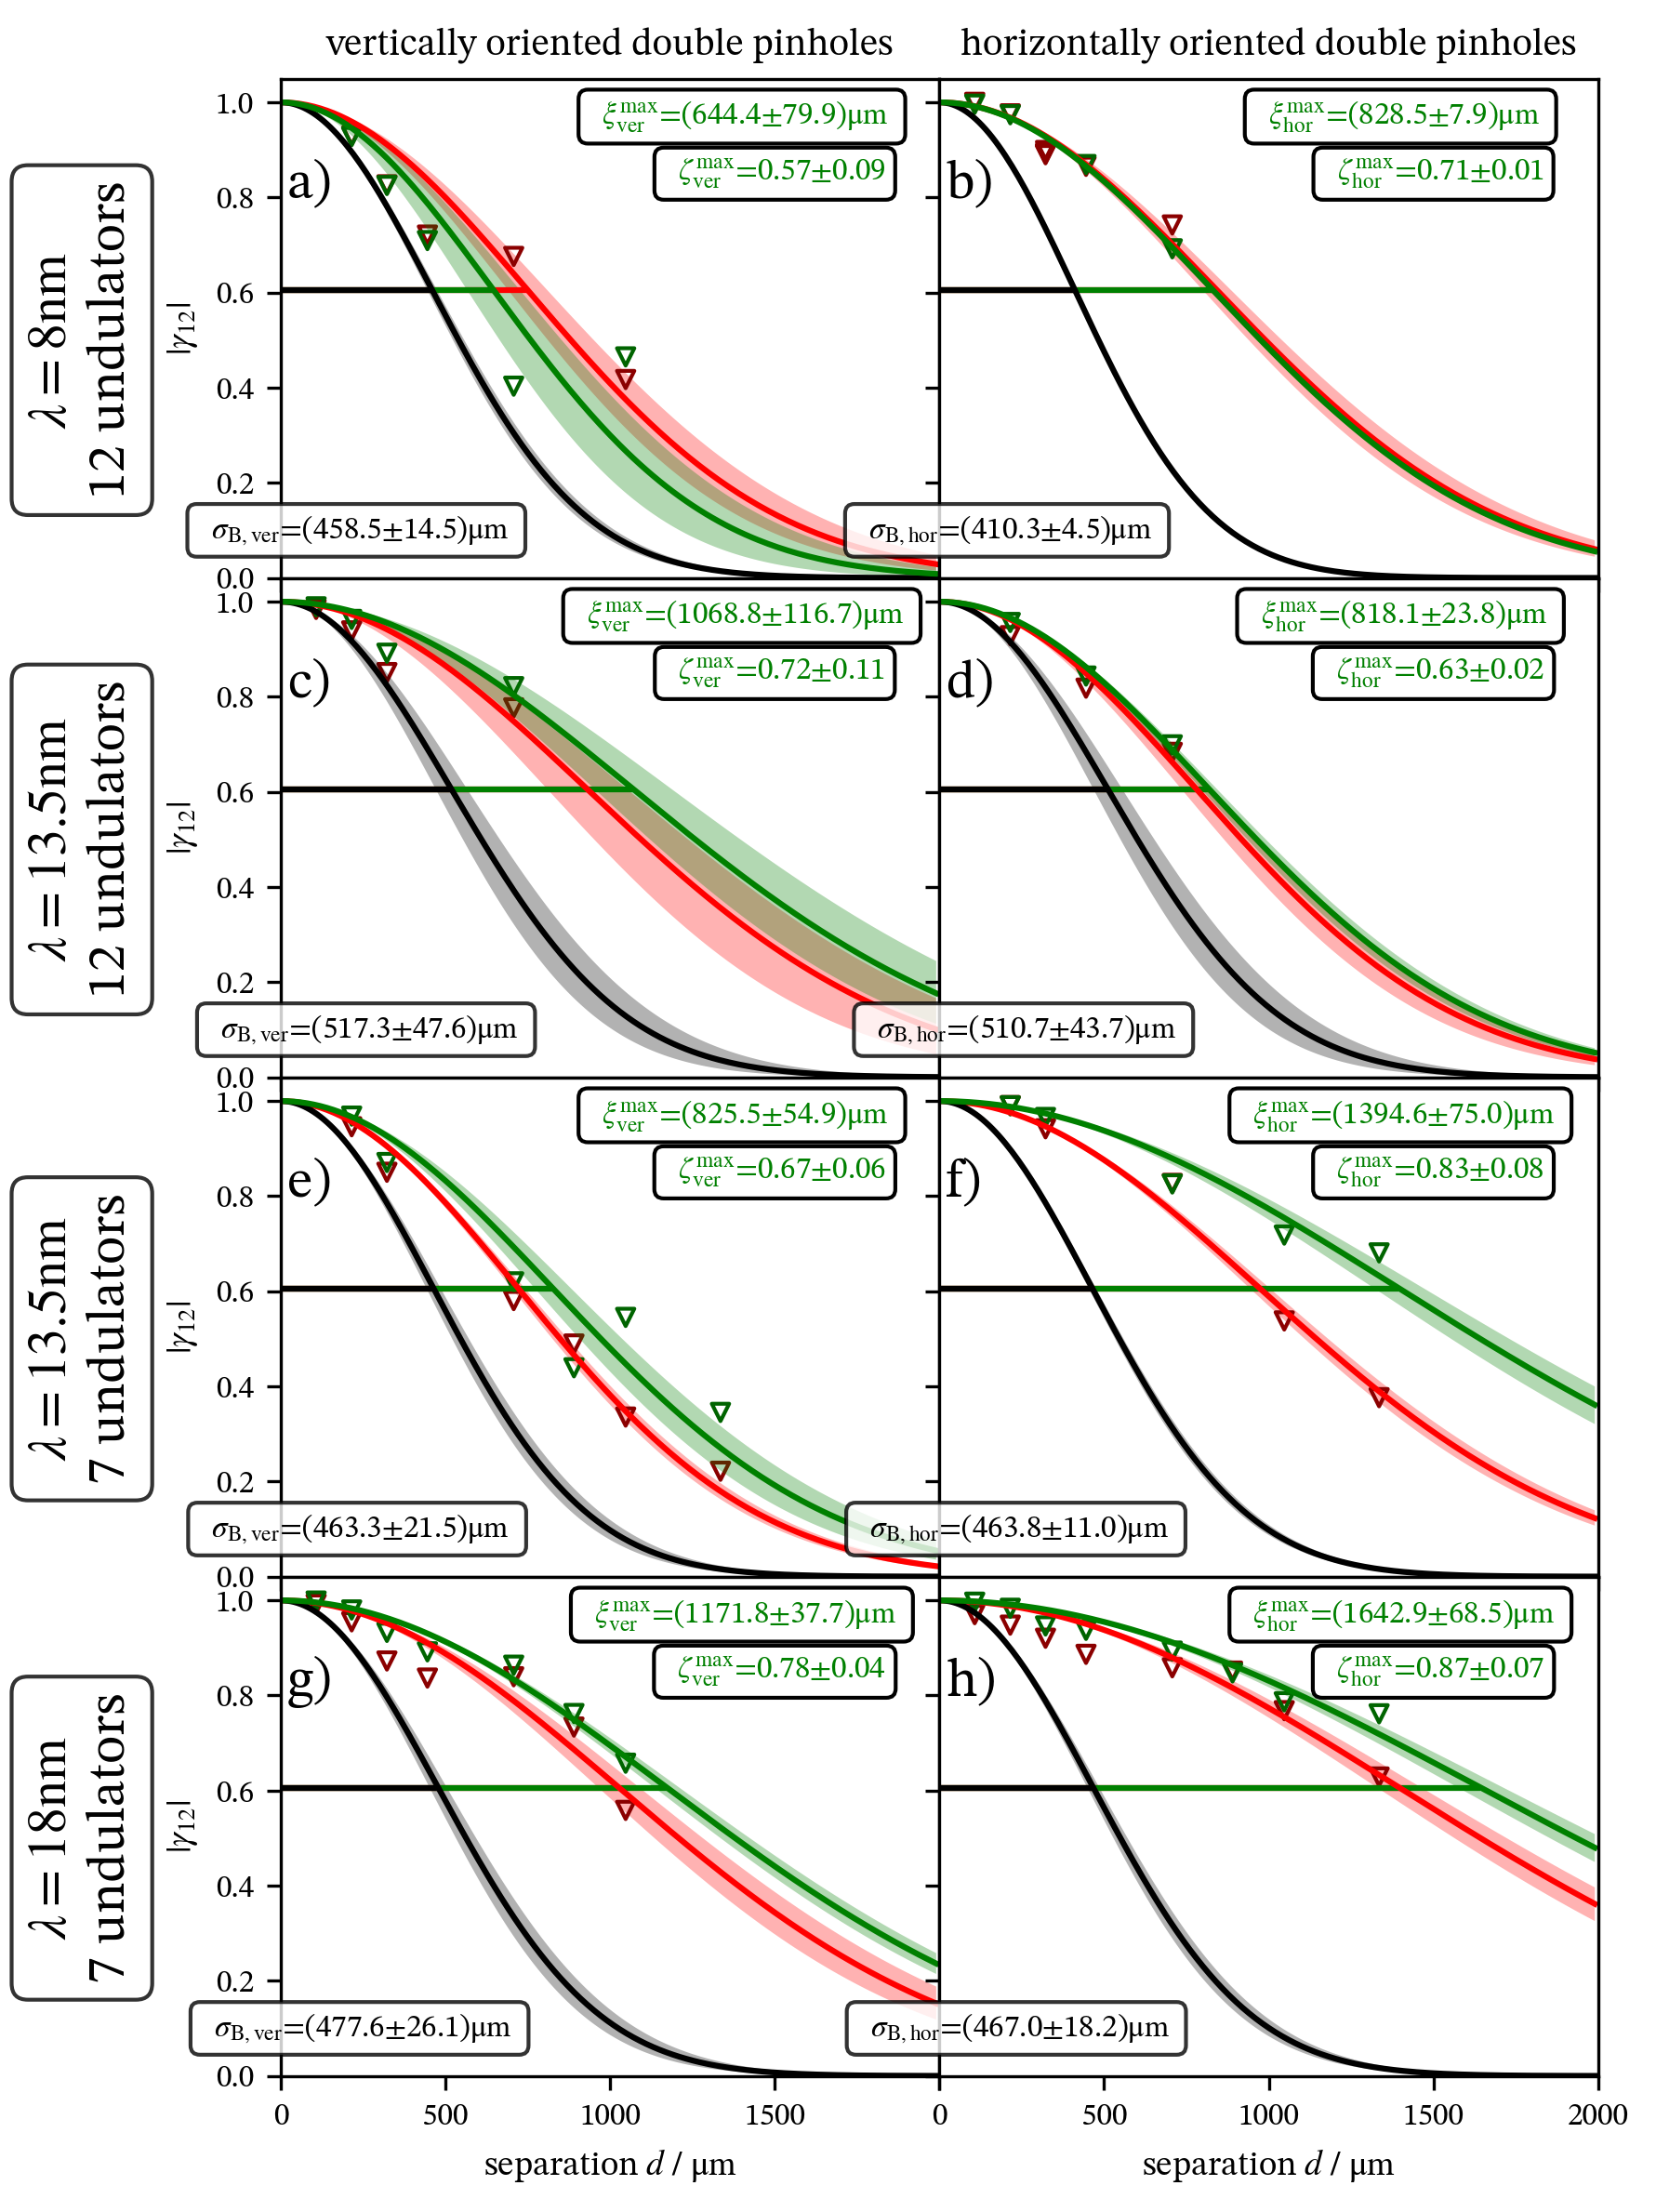

In [53]:
def plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults):
# do_settingtext, do_title, do_xlabel)
    label = label

    print(str(setting_wavelength_nm) +'nm ' + str(setting_undulators) + 'und. ' + orientation)

    if plotfitresults == True:
        if do_plotmeanresults == True:
            x = np.arange(0.0, 2000, 10)
            y1 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit) for x in x]
            ax.plot(x, y1, '--', color='red')
            y2 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit-xi_um_fit_std) for x in x]
            y3 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit+xi_um_fit_std) for x in x]
            ax.fill_between(x, y2, y3, facecolor='red', alpha=0.3)

        # ax.hlines(0.606, 0, xi_um_fit, linestyles = 'dotted')
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        # t = ax.text(xi_um_fit/2, 0.53, "  $\\xi$=("+str(round(xi_um_fit,1))+'$\\pm$'+str(round(xi_um_fit_std,1))+')$\mathrm{\mu m}$  ', ha="center", va="center", rotation=0,
        #             size=8, color='black', bbox=props)


        x = xdata
        y = ydata
        yerr = yerr

        if do_plotmeanresults == True:
            plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4,
                capsize=2, elinewidth=1, markeredgewidth=1, color='darkred', fillstyle='none', label='average')


        x = np.arange(0.0, 2000, 10)
        y1 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit_max) for x in x]
        y2 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit_max-xi_um_fit_max_std) for x in x]
        y3 = [gaussian(x=x, amp=1, cen=0, sigma=xi_um_fit_max+xi_um_fit_max_std) for x in x]
        ax.fill_between(x, y2, y3, facecolor='red', alpha=0.3)
        ax.plot(x, y1, '-', color='red', label='')

        ax.hlines(0.606, 0, xi_um_fit_max, linestyles = '-', color='red')
        # ax.hlines(0.606, 0, xi_um_fit, linestyles = 'dotted')
        # props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        # t = ax.text(1400,0.95, "  $\\xi^{\mathrm{max}}$=("+str(round(xi_um_fit_max,1))+'$\\pm$'+str(round(xi_um_fit_std_max,1))+')$\mathrm{\mu m}$  ', ha="center", va="center", rotation=0,
        #             size=8, color='red', bbox=props)

        x = xdata
        y = ydata_max
        # ax.scatter(x,y, marker='x', s=6, color='red', label='maximum')
        ax.scatter(x,y, marker='v', s=20, facecolors='none', edgecolors='darkred', label='maximum')



    x = np.arange(0.0, 2000, 10)
    y_B = [gaussian(x=x, amp=1, cen=0, sigma=sigma_B_um) for x in x]
    ax.plot(x, y_B, '-', color='black', label='Intensity')
    y2 = [gaussian(x=x, amp=1, cen=0, sigma=sigma_B_um-sigma_B_um_std) for x in x]
    y3 = [gaussian(x=x, amp=1, cen=0, sigma=sigma_B_um+sigma_B_um_std) for x in x]
    ax.fill_between(x, y2, y3, facecolor='black', alpha=0.3)


    # find sigma!!!?
    xi_x_mean = np.average(xi_x_um, weights=xi_x_um_std.apply(lambda x: 1.0/x**2))
    xi_x_std = np.sqrt(1.0/xi_x_um_std.apply(lambda x: 1.0/x**2).sum())
    print('xi_x_um='+str(round(xi_x_mean,1)) + ' \pm ' + str(round(xi_x_std,1)))
    y_xi_x_mean = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_mean) for x in x]
    if do_plotmeanresults == True:
        ax.plot(x, y_xi_x_mean, linestyle='--', color='green')
    y_xi_x_minusstd = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_mean-xi_x_std) for x in x]
    y_xi_x_plusstd = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_mean+xi_x_std) for x in x]
    if do_plotmeanresults == True:
        ax.fill_between(x, y_xi_x_plusstd, y_xi_x_minusstd, facecolor='green', alpha=0.3)
    d_gamma = [np.nan] * 10
    d_gamma = np.array(d_gamma)
    xi_x_um_max = [np.nan] * 10
    gamma_xi_x_um_max = [np.nan] * 10
    for i in range(len(xi_x_um)):
        x = d_um.iloc[i]
        d_gamma[i] = d_um.iloc[i]
        y = gaussian(x=d_um.iloc[i], amp=1, cen=0, sigma=xi_x_um.iloc[i])
        y_plus_yerr = gaussian(x=d_um.iloc[i], amp=1, cen=0, sigma=xi_x_um.iloc[i]+xi_x_um_std.iloc[i])
        yerr = y_plus_yerr - y
        if do_plotmeanresults == True:
            if i==0:
                    plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4,
                            capsize=2, elinewidth=1, markeredgewidth=1, color='darkgreen', fillstyle='none', label='deconvolution method')
            else:
                    plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4,
                            capsize=2, elinewidth=1, markeredgewidth=1, color='darkgreen', fillstyle='none')
                
        xi_x_um_max[i] = df0[(df0['setting_wavelength_nm']==setting_wavelength_nm) \
                        & (df0['setting_undulators']==setting_undulators) \
                        & (df0['orientation']==orientation) \
                        & (df0['separation_um']==d_um.iloc[i])]['xi_x_um'].max()
        if ~np.isnan(xi_x_um_max[i]):
            y = gaussian(x=d_um.iloc[i], amp=1, cen=0, sigma=xi_x_um_max[i])
            gamma_xi_x_um_max[i] = y
            ax.scatter(x,y, marker='v', s=20, color='darkgreen', facecolors='none', label='maximum') # xi_x_um_max scatter
        else:
            gamma_xi_x_um_max[i] = np.nan

    x = np.arange(0.0, 2000, 10)
    gamma_xi_x_um_max = np.array(gamma_xi_x_um_max)
    d_gamma = d_gamma[~np.isnan(gamma_xi_x_um_max)]
    gamma_xi_x_um_max = gamma_xi_x_um_max[~np.isnan(gamma_xi_x_um_max)]
    (xi_x_um_max_sigma, xi_x_um_max_sigma_std) = find_sigma(d_gamma,gamma_xi_x_um_max,0, 400, False)
    y1 = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_um_max_sigma) for x in x]
    ax.plot(x, y1, '-', color='green', label='') # xi_x_um_max plot
    y_min = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_um_max_sigma-xi_x_um_max_sigma_std) for x in x]
    y_max = [gaussian(x=x, amp=1, cen=0, sigma=xi_x_um_max_sigma+xi_x_um_max_sigma_std) for x in x]
    ax.fill_between(x, y_min, y_max, facecolor='green', alpha=0.3)
    # ax.hlines(0.606, 0, np.nanmean(xi_x_um_max), linestyles = '-', color='green')
    ax.hlines(0.606, 0, np.nanmean(xi_x_um_max_sigma), linestyles = '-', color='green')
    ax.hlines(0.606, 0, np.nanmean(sigma_B_um), linestyles = '-', color='black')

    zeta_deconv_mean = zeta(xi_x_mean,sigma_B_um)
    zeta_deconv_std = zeta(xi_x_std,sigma_B_um)

    zeta_deconv_max = zeta(xi_x_um_max_sigma,sigma_B_um)
    zeta_deconv_max_std = zeta(xi_x_um_max_sigma_std,sigma_B_um)
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    t = ax.text(1400,0.97, "  $\\xi^{\mathrm{max}}_{\mathrm{"+orientation[0:3]+"}}$=("+str(round(xi_x_um_max_sigma,1))+'$\\pm$'+str(round(xi_x_um_max_sigma_std,1))+')$\mathrm{\mu m}$  ', ha="center", va="center", rotation=0,
            size=8, color='green', bbox=props)
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    t = ax.text(1500,0.85, "  $\\zeta^{\mathrm{max}}_{\mathrm{"+orientation[0:3]+"}}$="+str(round(zeta_deconv_max,2))+'$\\pm$'+str(round(zeta_deconv_max_std,2)), ha="center", va="center", rotation=0,
            size=8, color='green', bbox=props)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    t = ax.text(sigma_B_um/2, 0.1, "  $\\sigma_{\mathrm{B,"+orientation[0:3]+"}}$=("+str(round(sigma_B_um,1))+'$\\pm$'+str(round(sigma_B_um_std,1))+')$\mathrm{\mu m}$  ', ha="center", va="center", rotation=0,
            size=8, color='black', bbox=props)
    ax.set_xlim([0,2000])

    # t = ax.text(400, 0.35, '$\zeta_{\mathrm{ver}}^{\mathrm{max}}=$'  + str(round(zeta_fit_um_max,2)) + '$\pm$' + str(round(zeta_fit_max_std,2)), ha="center", va="center", rotation=0, size=8, color='red')
    # t = ax.text(400, 0.25, '$\zeta_{\mathrm{ver}}=$'  + str(round(zeta_fit_um,2)) + '$\pm$' + str(round(zeta_fit_um_std_8nm_S_ver,2)), ha="center", va="center", rotation=0, size=8, color='black')
    print('xi_um_max='  + str(round(xi_x_um_max_sigma,1)) + ' \pm ' + str(round(xi_x_um_max_sigma_std,1)))
    print('zeta='  + str(round(zeta_deconv_mean,2)) + ' \pm ' + str(round(zeta_deconv_std,2)))
    print('zeta_max='  + str(round(zeta_deconv_max,2)) + ' \pm ' + str(round(zeta_deconv_max_std,2)))
    

    # ax.set_xlabel('separation $ d~/~\mathrm{\mu m}$')
    ax.set_ylabel(ylabeltext)

    # ax.set_title('$\lambda=8nm$, 12 undulators, vertical')
    ax.set_title(titletext, fontsize=10)
    
    # plt.legend()
    ax.set_ylim([0,1.05])
    ax.text(20,0.8,subfigurelabeltext, fontsize=14)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(-500,0.5,settingtext, fontsize=14, rotation=90, ha='center', rotation_mode='anchor', bbox=props)



plotfitresults = True
# plotfitresults = False

do_plotmeanresults = False

fig = plt.figure(figsize=[6, 8], constrained_layout=True)

gs = gridspec.GridSpec(nrows=4, ncols=2, figure=fig)
gs.update(hspace=0, wspace=0.0)




ax = plt.subplot(gs[0,0])

label = '8nm vertical S'
setting_wavelength_nm = 8
setting_undulators = 12
orientation = 'vertical'
xdata = xdata_8nm_S_ver
ydata = ydata_8nm_S_ver
yerr = ydata_std_8nm_S_ver
xi_um_fit = xi_um_fit_8nm_S_ver
xi_um_fit_std = xi_um_fit_stderr_8nm_S_ver
xi_um_fit_max = xi_um_fit_8nm_S_ver_max
xi_um_fit_max_std = xi_um_fit_stderr_8nm_S_ver_max
ydata_max = ydata_8nm_S_ver_max
sigma_B_um = sigma_B_um_8nm_S_ver
sigma_B_um_std = sigma_B_um_err_8nm_S_ver
xi_x_um = xi_x_um_8nm_S_ver
xi_x_um_std = xi_x_um_std_8nm_S_ver
d_um = d_um_8nm_S_ver
zeta_fit = zeta_fit_um_8nm_S_ver
zeta_fit_std = zeta_fit_um_std_8nm_S_ver
zeta_fit_max = zeta_fit_um_8nm_S_ver_max
zeta_fit_max_std = zeta_fit_um_std_8nm_S_ver_max
settingtext = '$\lambda=8\mathrm{nm}$\n12 undulators'
titletext = 'vertically oriented double pinholes'
ylabeltext = '$|\gamma_{12}|$'
subfigurelabeltext = 'a)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])

ax = plt.subplot(gs[0,1])

label = '8nm vertical S'
setting_wavelength_nm = 8
setting_undulators = 12
orientation = 'horizontal'
xdata = xdata_8nm_S_hor
ydata = ydata_8nm_S_hor
yerr = ydata_std_8nm_S_hor
xi_um_fit = xi_um_fit_8nm_S_hor
xi_um_fit_std = xi_um_fit_stderr_8nm_S_hor
xi_um_fit_max = xi_um_fit_8nm_S_hor_max
xi_um_fit_max_std = xi_um_fit_stderr_8nm_S_hor_max
ydata_max = ydata_8nm_S_hor_max
sigma_B_um = sigma_B_um_8nm_S_hor
sigma_B_um_std = sigma_B_um_err_8nm_S_hor
xi_x_um = xi_x_um_8nm_S_hor
xi_x_um_std = xi_x_um_std_8nm_S_hor
d_um = d_um_8nm_S_hor
zeta_fit = zeta_fit_um_8nm_S_hor
zeta_fit_std = zeta_fit_um_std_8nm_S_hor
zeta_fit_max = zeta_fit_um_8nm_S_hor_max
zeta_fit_max_std = zeta_fit_um_std_8nm_S_hor_max
settingtext = ''
titletext = 'horizontally oriented double pinholes'
ylabeltext = ''
subfigurelabeltext = 'b)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = plt.subplot(gs[1,0])

label = '13.5nm vertical S'
setting_wavelength_nm = 13.5
setting_undulators = 12
orientation = 'vertical'
xdata = xdata_13p5nm_S_ver
ydata = ydata_13p5nm_S_ver
yerr = ydata_std_13p5nm_S_ver
xi_um_fit = xi_um_fit_13p5nm_S_ver
xi_um_fit_std = xi_um_fit_stderr_13p5nm_S_ver
xi_um_fit_max = xi_um_fit_13p5nm_S_ver_max
xi_um_fit_max_std = xi_um_fit_stderr_13p5nm_S_ver_max
ydata_max = ydata_13p5nm_S_ver_max
sigma_B_um = sigma_B_um_13p5nm_S_ver
sigma_B_um_std = sigma_B_um_err_13p5nm_S_ver
xi_x_um = xi_x_um_13p5nm_S_ver
xi_x_um_std = xi_x_um_std_13p5nm_S_ver
d_um = d_um_13p5nm_S_ver
zeta_fit = zeta_fit_um_13p5nm_S_ver
zeta_fit_std = zeta_fit_um_std_13p5nm_S_ver
zeta_fit_max = zeta_fit_um_13p5nm_S_ver_max
zeta_fit_max_std = zeta_fit_um_std_13p5nm_S_ver_max
settingtext = '$\lambda=13.5\mathrm{nm}$\n12 undulators'
titletext = ''
ylabeltext = '$|\gamma_{12}|$'
subfigurelabeltext = 'c)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext,titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])


ax = plt.subplot(gs[1,1])

label = '13.5nm horizontal S'
setting_wavelength_nm = 13.5
setting_undulators = 12
orientation = 'horizontal'
xdata = xdata_13p5nm_S_hor
ydata = ydata_13p5nm_S_hor
yerr = ydata_std_13p5nm_S_hor
xi_um_fit = xi_um_fit_13p5nm_S_hor
xi_um_fit_std = xi_um_fit_stderr_13p5nm_S_hor
xi_um_fit_max = xi_um_fit_13p5nm_S_hor_max
xi_um_fit_max_std = xi_um_fit_stderr_13p5nm_S_hor_max
ydata_max = ydata_13p5nm_S_hor_max
sigma_B_um = sigma_B_um_13p5nm_S_hor
sigma_B_um_std = sigma_B_um_err_13p5nm_S_hor
xi_x_um = xi_x_um_13p5nm_S_hor
xi_x_um_std = xi_x_um_std_13p5nm_S_hor
d_um = d_um_13p5nm_S_hor
zeta_fit = zeta_fit_um_13p5nm_S_hor
zeta_fit_std = zeta_fit_um_std_13p5nm_S_hor
zeta_fit_max = zeta_fit_um_13p5nm_S_hor_max
zeta_fit_max_std = zeta_fit_um_std_13p5nm_S_hor_max
settingtext = ''
titletext = ''
ylabeltext = ''
subfigurelabeltext = 'd)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])
ax.set_yticklabels([])


ax = plt.subplot(gs[2,0])

label = '13.5nm#1 vertical S'
setting_wavelength_nm = 13.5
setting_undulators = 7
orientation = 'vertical'
xdata = xdata_13p5nm_1_S_ver
ydata = ydata_13p5nm_1_S_ver
yerr = ydata_std_13p5nm_1_S_ver
xi_um_fit = xi_um_fit_13p5nm_1_S_ver
xi_um_fit_std = xi_um_fit_stderr_13p5nm_1_S_ver
xi_um_fit_max = xi_um_fit_13p5nm_1_S_ver_max
xi_um_fit_max_std = xi_um_fit_stderr_13p5nm_1_S_ver_max
ydata_max = ydata_13p5nm_1_S_ver_max
sigma_B_um = sigma_B_um_13p5nm_1_S_ver
sigma_B_um_std = sigma_B_um_err_13p5nm_1_S_ver
xi_x_um = xi_x_um_13p5nm_1_S_ver
xi_x_um_std = xi_x_um_std_13p5nm_1_S_ver
d_um = d_um_13p5nm_1_S_ver
zeta_fit = zeta_fit_um_13p5nm_1_S_ver
zeta_fit_std = zeta_fit_um_std_13p5nm_1_S_ver
zeta_fit_max = zeta_fit_um_13p5nm_1_S_ver_max
zeta_fit_max_std = zeta_fit_um_std_13p5nm_1_S_ver_max
settingtext = '$\lambda=13.5\mathrm{nm}$\n7 undulators'
titletext = ''
ylabeltext = '$|\gamma_{12}|$'
subfigurelabeltext = 'e)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext,titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])


ax = plt.subplot(gs[2,1])

label = '13.5nm#1 horizontal S'
setting_wavelength_nm = 13.5
setting_undulators = 7
orientation = 'horizontal'
xdata = xdata_13p5nm_1_S_hor
ydata = ydata_13p5nm_1_S_hor
yerr = ydata_std_13p5nm_1_S_hor
xi_um_fit = xi_um_fit_13p5nm_1_S_hor
xi_um_fit_std = xi_um_fit_stderr_13p5nm_1_S_hor
xi_um_fit_max = xi_um_fit_13p5nm_1_S_hor_max
xi_um_fit_max_std = xi_um_fit_stderr_13p5nm_1_S_hor_max
ydata_max = ydata_13p5nm_1_S_hor_max
sigma_B_um = sigma_B_um_13p5nm_1_S_hor
sigma_B_um_std = sigma_B_um_err_13p5nm_1_S_hor
xi_x_um = xi_x_um_13p5nm_1_S_hor
xi_x_um_std = xi_x_um_std_13p5nm_1_S_hor
d_um = d_um_13p5nm_1_S_hor
zeta_fit = zeta_fit_um_13p5nm_1_S_hor
zeta_fit_std = zeta_fit_um_std_13p5nm_1_S_hor
zeta_fit_max = zeta_fit_um_13p5nm_1_S_hor_max
zeta_fit_max_std = zeta_fit_um_std_13p5nm_1_S_hor_max
settingtext = ''
titletext = ''
ylabeltext = ''
subfigurelabeltext = 'f)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([])
ax.set_yticklabels([])



ax = plt.subplot(gs[3,0])

label = '18nm vertical S'
setting_wavelength_nm = 18
setting_undulators = 7
orientation = 'vertical'
xdata = xdata_18nm_S_ver
ydata = ydata_18nm_S_ver
yerr = ydata_std_18nm_S_ver
xi_um_fit = xi_um_fit_18nm_S_ver
xi_um_fit_std = xi_um_fit_stderr_18nm_S_ver
xi_um_fit_max = xi_um_fit_18nm_S_ver_max
xi_um_fit_max_std = xi_um_fit_stderr_18nm_S_ver_max
ydata_max = ydata_18nm_S_ver_max
sigma_B_um = sigma_B_um_18nm_S_ver
sigma_B_um_std = sigma_B_um_err_18nm_S_ver
xi_x_um = xi_x_um_18nm_S_ver
xi_x_um_std = xi_x_um_std_18nm_S_ver
d_um = d_um_18nm_S_ver
zeta_fit = zeta_fit_um_18nm_S_ver
zeta_fit_std = zeta_fit_um_std_18nm_S_ver
zeta_fit_max = zeta_fit_um_18nm_S_ver_max
zeta_fit_max_std = zeta_fit_um_std_18nm_S_ver_max
settingtext = '$\lambda=18\mathrm{nm}$\n7 undulators'
titletext = ''
ylabeltext = '$|\gamma_{12}|$'
subfigurelabeltext = 'g)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext,titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_xticklabels([0,500,1000,1500])
ax.set_xlabel('separation $ d~/~\mathrm{\mu m}$')

ax = plt.subplot(gs[3,1])

label = '18nm horizontal S'
setting_wavelength_nm = 18
setting_undulators = 7
orientation = 'horizontal'
xdata = xdata_18nm_S_hor
ydata = ydata_18nm_S_hor
yerr = ydata_std_18nm_S_hor
xi_um_fit = xi_um_fit_18nm_S_hor
xi_um_fit_std = xi_um_fit_stderr_18nm_S_hor
xi_um_fit_max = xi_um_fit_18nm_S_hor_max
xi_um_fit_max_std = xi_um_fit_stderr_18nm_S_hor_max
ydata_max = ydata_18nm_S_hor_max
sigma_B_um = sigma_B_um_18nm_S_hor
sigma_B_um_std = sigma_B_um_err_18nm_S_hor
xi_x_um = xi_x_um_18nm_S_hor
xi_x_um_std = xi_x_um_std_18nm_S_hor
d_um = d_um_18nm_S_hor
zeta_fit = zeta_fit_um_18nm_S_hor
zeta_fit_std = zeta_fit_um_std_18nm_S_hor
zeta_fit_max = zeta_fit_um_18nm_S_hor_max
zeta_fit_max_std = zeta_fit_um_std_18nm_S_hor_max
settingtext = ''
titletext = ''
ylabeltext = ''
subfigurelabeltext = 'h)'

plot_CDC(ax, label, setting_wavelength_nm, setting_undulators, orientation, xdata, ydata, yerr, xi_um_fit, xi_um_fit_std, xi_um_fit_max, xi_um_fit_max_std, ydata_max, sigma_B_um, sigma_B_um_std, xi_x_um, xi_x_um_std, d_um, zeta_fit, zeta_fit_std, zeta_fit_max, zeta_fit_max_std, settingtext, titletext, ylabeltext, subfigurelabeltext, plotfitresults, do_plotmeanresults)
ax.set_yticklabels([])
ax.set_xlabel('separation $ d~/~\mathrm{\mu m}$')





plt.tight_layout()

savefigure = True
if plotfitresults == True:
    fname = 'results_overview_with_fitresults'
else:
    fname = 'results_overview'
if savefigure == True:
    fig.savefig(fname+'.pdf', bbox_inches = 'tight')
    fig.savefig(fname+'.svg', bbox_inches = 'tight')
    fig.savefig(fname+'.png', bbox_inches = 'tight')

